In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Flatten, Add, Dropout, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Reshape, multiply, add, concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from keras.initializers import he_normal

In [2]:
# data preparation
dataset_dir =  r'D:\Project\Deep Learning - Research\programs\MV-couswork\Brain Tumor Data Set\BrainTumorProcessed'
input_shape = (256, 256, 3)
batch_size = 4
num_classes = 2

In [3]:
# data augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = ImageDataGenerator(
rescale = 1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 3103 images belonging to 2 classes.
Found 665 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


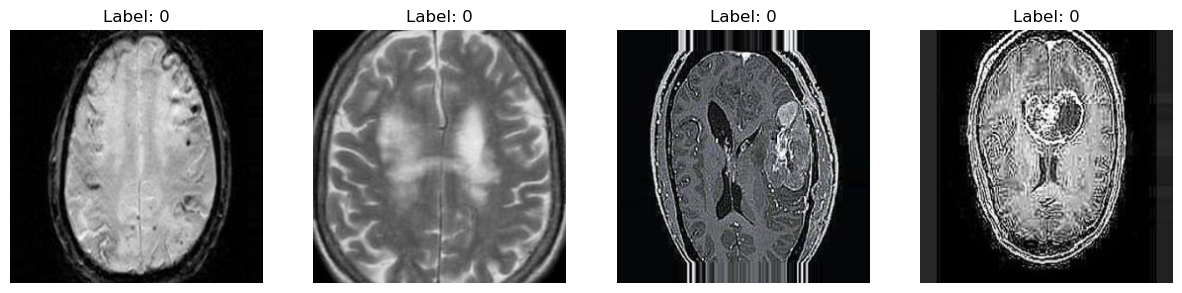

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def residual_block(inputs, num_filter):
    # Convolution layers
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(inputs)
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Skip connection
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(2*num_filter, kernel_size=(1,1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut=inputs
        
    shortcut = MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(shortcut)
    # add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [7]:
def cbam_block(cbam_feature, ratio=8):
    # Channel Attention Module
    channel_avg = GlobalAveragePooling2D()(cbam_feature)
    channel_max = GlobalAveragePooling2D()(cbam_feature)
    channel_avg = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_avg)
    channel_max = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_attention = multiply([cbam_feature, channel_avg + channel_max])

    # Spatial Attention Module
    spatial_avg = K.mean(channel_attention, axis=-1, keepdims=True)
    spatial_max = K.max(channel_attention, axis=-1, keepdims=True)
    spatial_attention = add([spatial_avg, spatial_max])
    spatial_attention = Activation('sigmoid')(spatial_attention)

    return multiply([channel_attention, spatial_attention])


In [8]:
def model1(inputs):
    
    x = residual_block(inputs, 64) # 2 conv layers
    
    x = cbam_block(x)
    
    x = residual_block(x, 256) # 2 conv layers
    
    x = cbam_block(x)
    
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    return x

In [9]:
def inception_module(x, filters):
    # 1x1 卷积
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 卷积 + 3x3 卷积
    conv1x1_2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    # 1x1 卷积 + 5x5 卷积
    conv1x1_3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    # 3x3 最大池化 + 1x1 卷积
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # 拼接所有分支
    inception = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)
    return inception

In [10]:
def model2(inputs):
     # 第一个卷积层
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # 第二个卷积层
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception 模块
    x = inception_module(x, [64, 128, 128, 128, 128, 128])
    x = inception_module(x, [128, 192, 192, 192, 192, 192])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # 全局平均池化
    x = AveragePooling2D((2, 2))(x)
    
    return x

In [11]:
 def Models(inputs_shape):    
    inputs = Input(shape=input_shape)
    
    branch1 = model1(inputs)
    branch2 = model2(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    x = cbam_block(x)

#     x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [12]:
model = Models(input_shape)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
import keras.backend as K


# 定义自定义的binary_crossentropy损失函数
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # 添加一个小的常数以防止log(0)的情况
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)  # 对预测值进行剪切，确保在 (epsilon, 1-epsilon) 范围内
    loss = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    return K.mean(loss, axis=-1)


def custom_accuracy(y_true, y_pred):
    # 将预测值四舍五入到最接近的整数（0或1）
    y_pred_rounded = K.round(y_pred)
    # 比较四舍五入后的预测值和真实标签，计算匹配的比例
    accuracy = K.mean(K.equal(y_true, y_pred_rounded))
    return accuracy


In [15]:
from tensorflow.keras.optimizers import Adagrad

custom_optimizer = Adagrad(learning_rate=0.01)

model.compile(loss=custom_binary_crossentropy, optimizer=custom_optimizer, metrics=[custom_accuracy])

In [16]:
history = model.fit(train_generator, epochs=60, validation_data =(validation_generator), verbose=1)

Epoch 1/60
776/776 [==============================] - 61s 73ms/step - loss: 16.1315 - custom_accuracy: 0.5319 - val_loss: 16.1527 - val_custom_accuracy: 0.5299
Epoch 2/60
776/776 [==============================] - 54s 70ms/step - loss: 16.1620 - custom_accuracy: 0.5321 - val_loss: 16.1527 - val_custom_accuracy: 0.5299
Epoch 3/60
776/776 [==============================] - 54s 70ms/step - loss: 16.1620 - custom_accuracy: 0.5320 - val_loss: 16.1527 - val_custom_accuracy: 0.5299
Epoch 4/60
776/776 [==============================] - 54s 70ms/step - loss: 16.1620 - custom_accuracy: 0.5322 - val_loss: 16.1527 - val_custom_accuracy: 0.5344
Epoch 5/60
776/776 [==============================] - 54s 70ms/step - loss: 16.1620 - custom_accuracy: 0.5320 - val_loss: 16.1527 - val_custom_accuracy: 0.5344
Epoch 6/60
776/776 [==============================] - 54s 70ms/step - loss: 16.1620 - custom_accuracy: 0.5320 - val_loss: 16.1527 - val_custom_accuracy: 0.5299
Epoch 7/60
776/776 [====================

In [17]:
# 画出训练和验证集上的准确率和损失曲线
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [20]:
loss, accurancy = model.evaluate(test_generator)
print('Test loss:', loss)
print("Test accurancy", accurancy)

In [21]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

In [22]:
#compute f1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

In [23]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [24]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [25]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

In [26]:
# model.save("VhRAE.h5")

In [27]:
# import netron
# netron.start("VhRAE.h5")